In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
from collections import defaultdict
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics import pairwise_distances, pairwise
from scipy.spatial.distance import cosine
from gensim import corpora
import nltk
import gensim
import plotly.express as px

#import pygal as py
#import squarify as sq
import matplotlib 
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline 

In [12]:
df = pd.read_csv("../Dataset/all-data.csv", encoding="ISO-8859-1", header=None) # heading = none

In [ ]:
df.head()

,0,1
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
len(df[0])

4846

In [ ]:
df.describe()

,0,1
count,4846,4846
unique,3,4838
top,neutral,TELECOMWORLDWIRE-7 April 2006-TJ Group Plc sel...
freq,2879,2


In [ ]:
df = df.set_axis(['sentiment', 'news'], axis=1, inplace=False)

In [ ]:
df.head()

,sentiment,news
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


# Duplicates count

In [ ]:
print('No. of duplicates in the dataset: {}'.format(sum(df.duplicated())))

No. of duplicates in the dataset: 6


# Null vals

In [ ]:
print('We have {} NaN/Null values in the dataset'.format(df.isnull().values.sum()))

We have 0 NaN/Null values in the dataset


# Class Count

In [ ]:
df.sentiment.value_counts()

neutral     2879
positive    1363
negative     604
Name: sentiment, dtype: int64

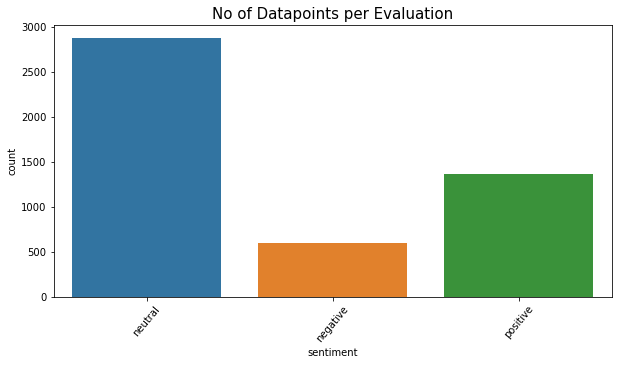

In [ ]:
plt.figure(figsize=(10,5))
plt.title('No of Datapoints per Evaluation', fontsize=15)
sns.countplot(df.sentiment)
plt.xticks(rotation=50)
plt.show()

In [ ]:
fig = px.pie(df, names='sentiment', title ='Pie chart of different sentiments of headlines')
fig.show()

# Revised dataset

In [ ]:
def preprocess(ReviewText):
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', ' ')  
    return ReviewText
df['Review Text'] = preprocess(df['news'])

df['polarity'] = df['news'].map(lambda text: TextBlob(text).sentiment.polarity)
df['news_len'] = df['news'].astype(str).apply(len)
df['word_count'] = df['news'].apply(lambda x: len(str(x).split()))

In [ ]:
df.head()

,sentiment,news,Review Text,polarity,news_len,word_count
0,neutral,"According to Gran , the company has no plans t...","According to Gran , the company has no plans t...",0.000000,127,25
1,neutral,Technopolis plans to develop in stages an area...,Technopolis plans to develop in stages an area...,0.083333,190,31
2,negative,The international electronic industry company ...,The international electronic industry company ...,0.000000,228,36
3,positive,With the new production plant the company woul...,With the new production plant the company woul...,-0.064802,206,33
4,positive,According to the company 's updated strategy f...,According to the company 's updated strategy f...,0.000000,203,41


## From texts and dictionary to bag-of-words

Now that we have our pre-processed corpus and we generated a dictionary based on it, we can start converting our texts into a more machine-readable format as a bag-of-words.

To do so, we can use the `.doc2bow()` method of Dictionary. The method:

1) count the occurrences for each distinct word
2) uses the dictionary mapping to represent each word with its id
3) provides a representation of the document as a sparse vector, i.e. as a list of $(id, freq)$ pairs, considering only ids (words) with a non zero frequency in the document.

Let's see how it works in practice

In [ ]:
stoplist = set('for a of the and to in , .'.split())
texts = [
    [word for word in document.lower().split() if word not in stoplist]
    for document in df["Review Text"]
]

In [ ]:
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts
]

In [ ]:
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
for i, doc in enumerate(corpus):
    print("document:\t", df["Review Text"][i])
    print("Bag-of-words:\t", [(dictionary[_id], freq) for _id, freq in doc])
    print()

document:	 According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Bag-of-words:	 [('according', 1), ('all', 1), ('although', 1), ('company', 2), ('gran', 1), ('growing', 1), ('has', 1), ('is', 2), ('move', 1), ('no', 1), ('plans', 1), ('production', 1), ('russia', 1), ('that', 1), ('where', 1)]

document:	 Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .
Bag-of-words:	 [('no', 1), ('plans', 1), ('100,000', 1), ('an', 1), ('area', 1), ('companies', 1), ('computer', 1), ('develop', 1), ('host', 1), ('less', 1), ('meters', 1), ('order', 1), ('said', 1), ('square', 1), ('stages', 1), ('statement', 1), ('technologies', 1), ('technopolis', 1), ('telecommunications', 1), ('than', 1), ('working', 1)]

document:	 The international electronic industry company Elcoteq has laid off tens

# From sparse matrices to the vector space

We are almost ready for our final steps. We now have to take our documents as bag-of-words and generate a dense document-term matrix, i.e. our first vector space.

Each row of the matrix represent a word. Each column a document. Each cell (i, j) tells us wheter word i appear in document j and with which frequency.  
The `gensim.matutils.corpus2dense()` function does the dirty work of creating the matrix from the corpus as list bag-of-words. Note that the function needs as a input both the corpus and the size of the dictionary (num_terms)

In [ ]:
numpy_matrix = gensim.matutils.corpus2dense(corpus,num_terms = len(dictionary))

In [ ]:
df_vectorspace = pd.DataFrame(numpy_matrix, index = [k for k,v in dictionary.token2id.items()], columns = df["Review Text"])
df_vectorspace.T

,according,all,although,company,gran,growing,has,is,move,no,...,arthritis,btt-1023,characteristics,generally,mg-kg,pharmacokinetic,ra,rheumatoid,tolerated,freenet
Review Text,,,,,,,,,,,,,,,,,,,,,
"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .",1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .",0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales .",1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LONDON MarketWatch -- Share prices ended lower in London Monday as a rebound in bank stocks failed to offset broader weakness for the FTSE 100 .,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Rinkuskiai 's beer sales fell by 6.5 per cent to 4.16 million litres , while Kauno Alus ' beer sales jumped by 6.9 per cent to 2.48 million litres .",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Operating profit fell to EUR 35.4 mn from EUR 68.8 mn in 2007 , including vessel sales gain of EUR 12.3 mn .",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Outliers

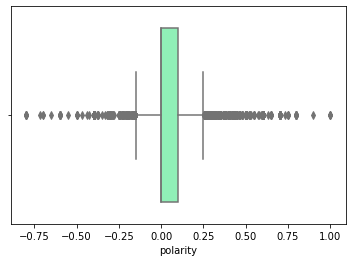

In [ ]:
sns.boxplot(df["polarity"],palette="rainbow",data=df)
plt.show()

# Distribution positive sentiment

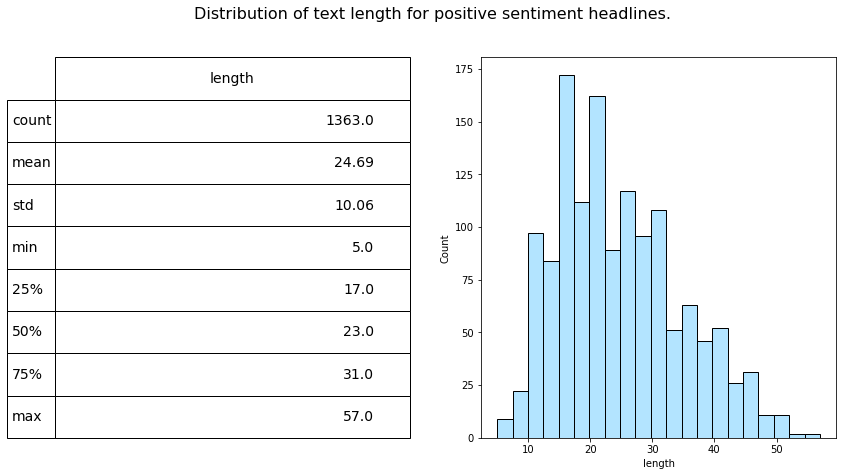

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df["Review Text"].str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['sentiment']=='positive']['length'], ax=ax1,color='#9ADCFF')
describe = df.length[df["sentiment"]=='positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment headlines.', fontsize=16)

plt.show()

# Distribution negative sentiment

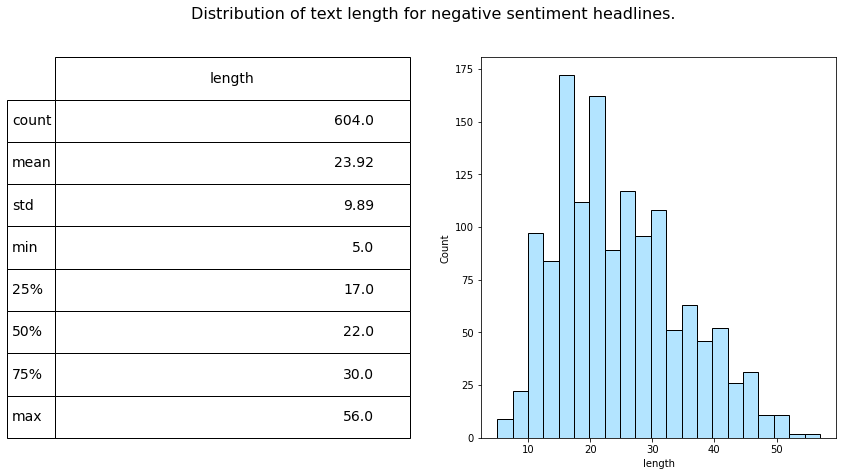

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df["Review Text"].str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['sentiment']=='positive']['length'], ax=ax1,color='#9ADCFF')
describe = df.length[df["sentiment"]=='negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for negative sentiment headlines.', fontsize=16)

plt.show()

# Distribution neutral sentiment

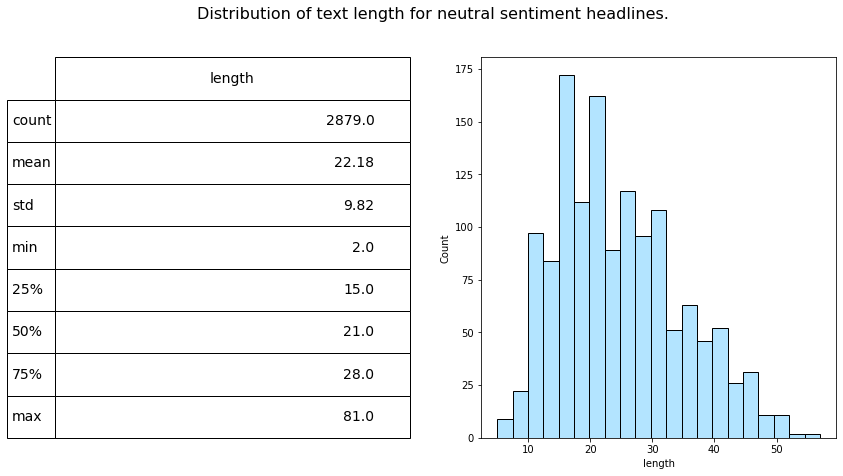

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df["Review Text"].str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['sentiment']=='positive']['length'], ax=ax1,color='#9ADCFF')
describe = df.length[df["sentiment"]=='neutral'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for neutral sentiment headlines.', fontsize=16)

plt.show()

# Sentiment polarity distribution

In [ ]:
p_s=df[df["polarity"]>0].count()["sentiment"]
neu_s=df[df["polarity"]==0].count()["sentiment"]
neg_s=df[df["polarity"]<0].count()["sentiment"]

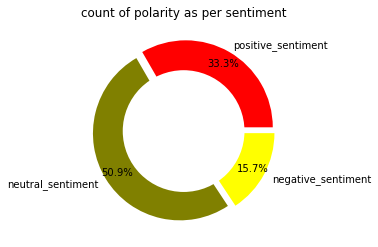

In [ ]:
# Setting labels for items in Chart
sentiment = ['positive_sentiment',"neutral_sentiment","negative_sentiment"]
  
# Setting size in Chart based on 
# given values
values = [p_s,neu_s,neg_s]
  
# colors
colors = ['#FF0000', 'olive', '#FFFF00']
# explosion
explode = (0.05, 0.05, 0.05)
  
# Pie Chart
plt.pie(values, colors=colors, labels=sentiment,
        autopct='%1.1f%%', pctdistance=0.85,
        explode=explode)
  
# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
  
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
  
# Adding Title of chart
plt.title('count of polarity as per sentiment')
  
# Displaing Chart
plt.show()

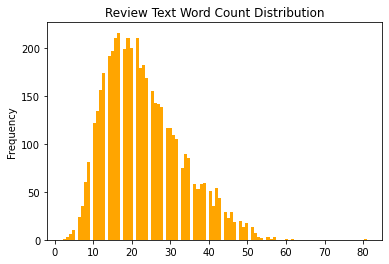

In [ ]:
df['word_count'].plot(
    kind='hist',
    bins=100,
    color="orange",
    title='Review Text Word Count Distribution');plt.show()

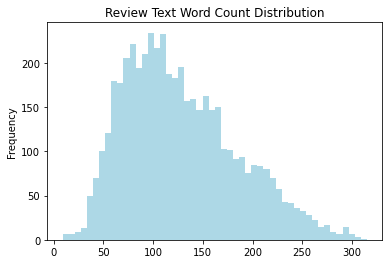

In [ ]:
df['news_len'].plot(
    kind='hist',
    bins=50,
    color="lightblue",
    title='Review Text Word Count Distribution');plt.show()

# Text Clouds

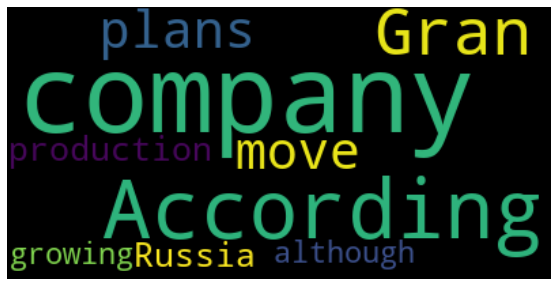

In [ ]:
# Start with one review:
plt.figure(figsize=(10,5))
text = df.news[0]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

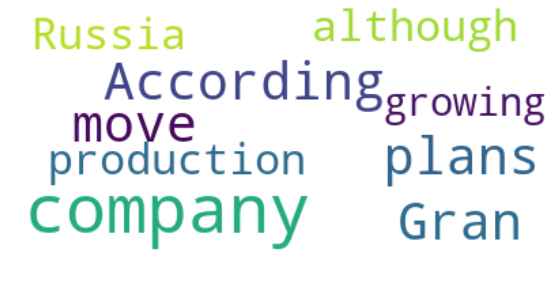

In [ ]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

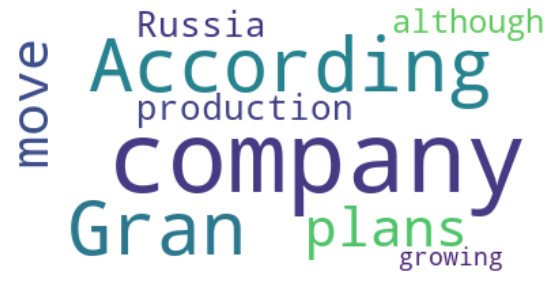

In [ ]:
# Create stopword list:
plt.figure(figsize=(10,5))
stopwords = set(STOPWORDS)
stopwords.update(["drink", "now", "wine", "flavor", "flavors"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Top words

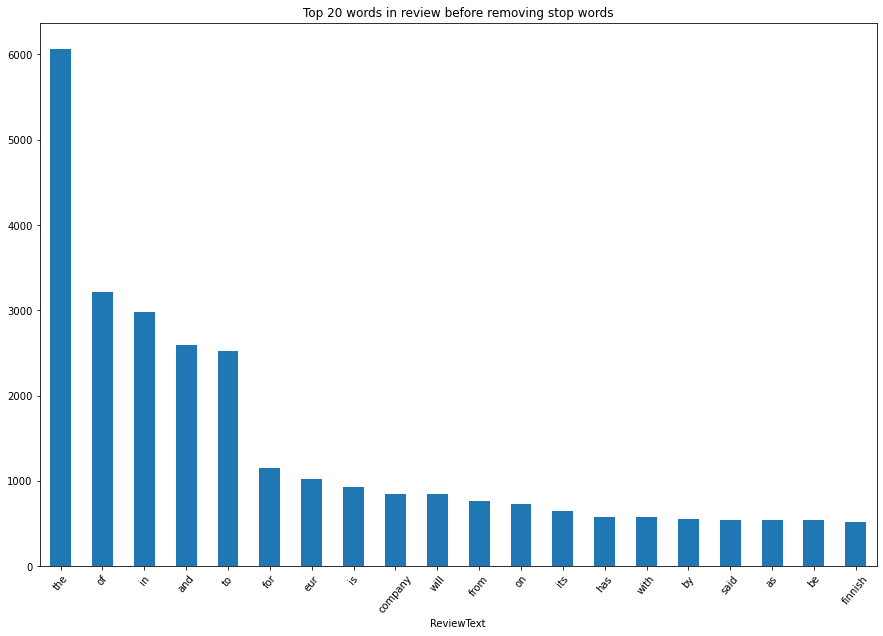

In [ ]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

plt.figure(figsize=(15,10))
common_words = get_top_n_words(df['Review Text'], 20)

df1 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df1.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',title='Top 20 words in review before removing stop words')
plt.xticks(rotation=50)
plt.show()

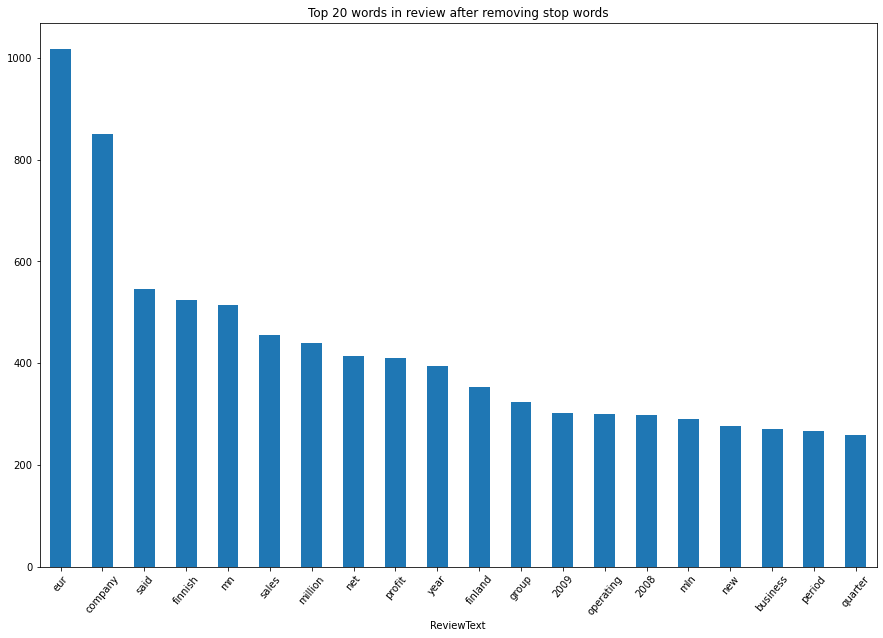

,ReviewText,count
0,eur,1018
1,company,851
2,said,545
3,finnish,524
4,mn,515
5,sales,455
6,million,440
7,net,413
8,profit,410
9,year,395


In [ ]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

plt.figure(figsize=(15,10))
common_words = get_top_n_words(df['Review Text'], 20)

df2 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df2.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words in review after removing stop words')
plt.xticks(rotation=50)
plt.show()
df2

# Top Bigrams

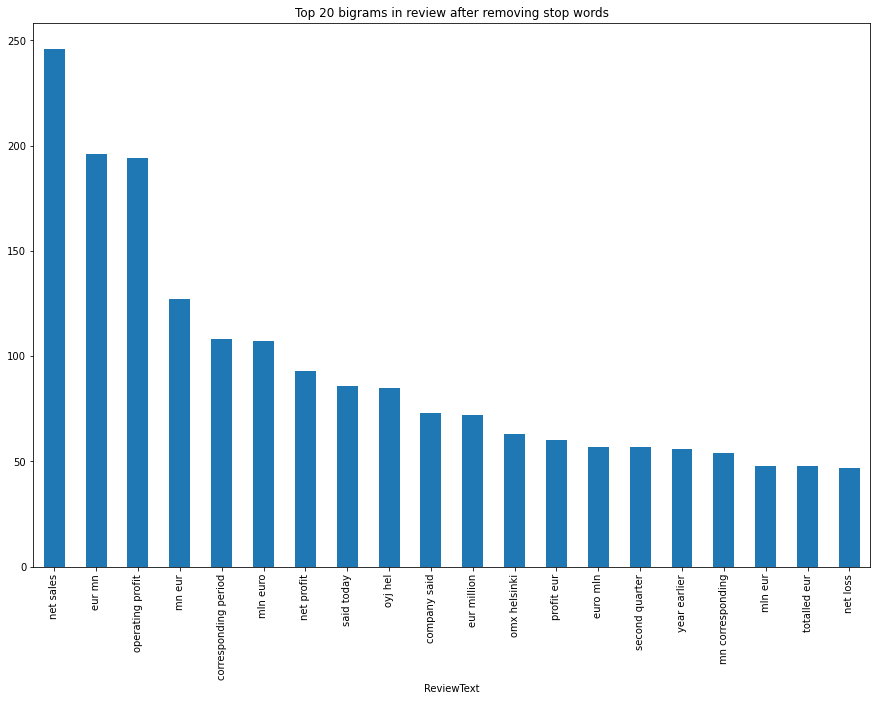

,ReviewText,count
0,net sales,246
1,eur mn,196
2,operating profit,194
3,mn eur,127
4,corresponding period,108
5,mln euro,107
6,net profit,93
7,said today,86
8,oyj hel,85
9,company said,73


In [ ]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

plt.figure(figsize=(15,10))
common_words = get_top_n_bigram(df['Review Text'], 20)

df4 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df4.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 bigrams in review after removing stop words')
plt.xticks(rotation=90)
plt.show()
df4

# Top Trigrams

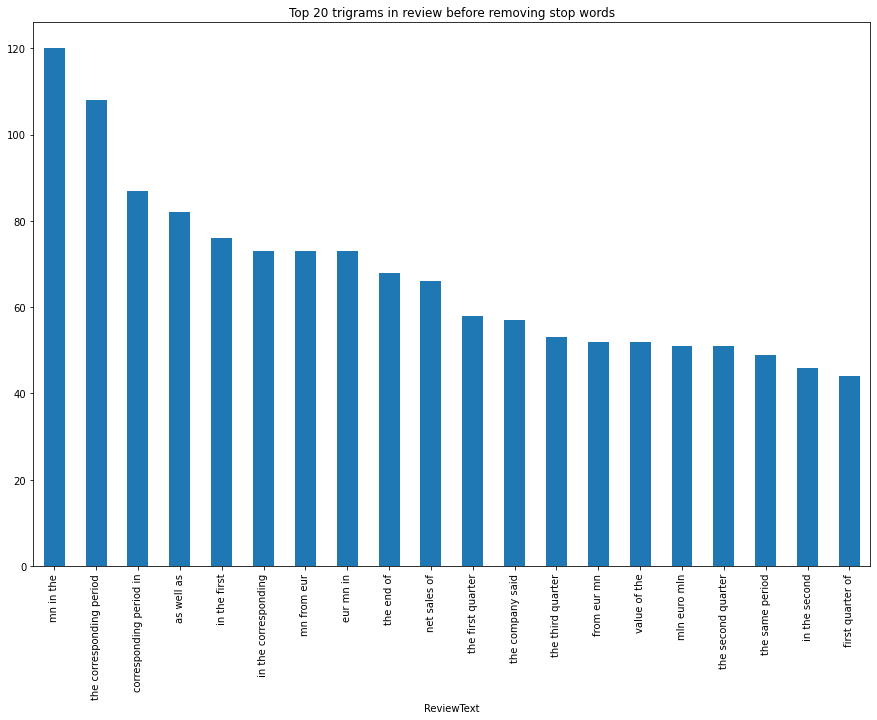

In [ ]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

plt.figure(figsize=(15,10))
common_words = get_top_n_trigram(df['Review Text'], 20)

df5 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df5.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 trigrams in review before removing stop words')
plt.xticks(rotation=90)
plt.show()

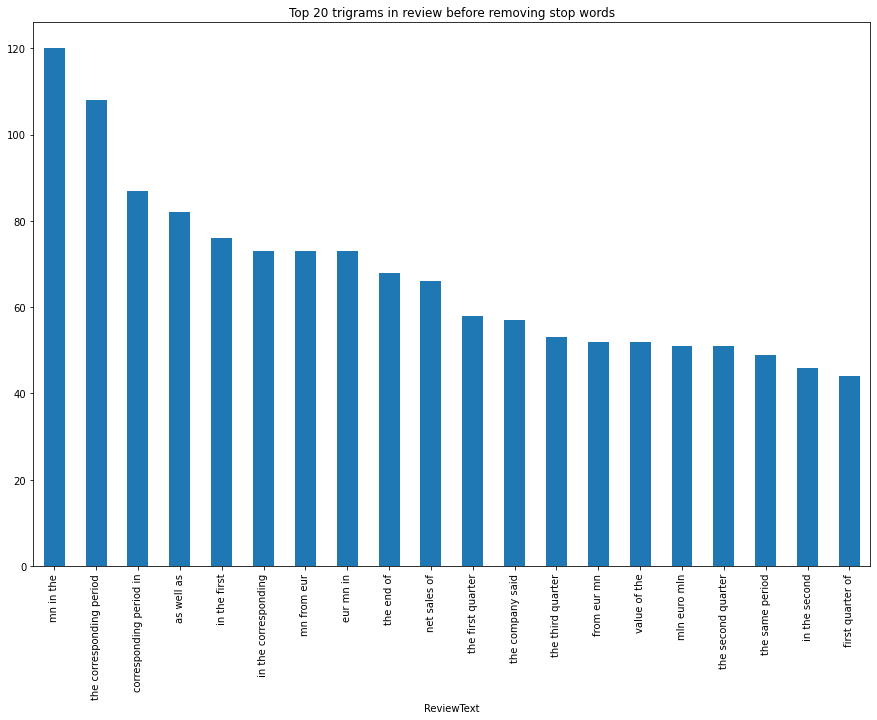

,ReviewText,count
0,mn in the,120
1,the corresponding period,108
2,corresponding period in,87
3,as well as,82
4,in the first,76
5,mn from eur,73
6,eur mn in,73
7,in the corresponding,73
8,the end of,68
9,net sales of,66


In [ ]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

plt.figure(figsize=(15,10))
common_words = get_top_n_trigram(df['Review Text'], 20)

df5 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df5.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 trigrams in review before removing stop words')
plt.xticks(rotation=90)
plt.show()
df5

# Part of speech

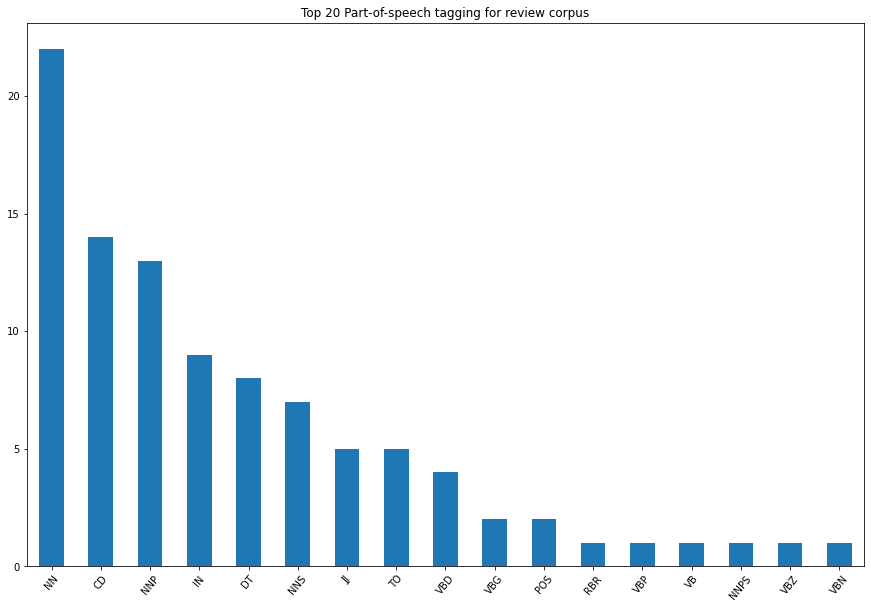

NN      22
CD      14
NNP     13
IN       9
DT       8
NNS      7
JJ       5
TO       5
VBD      4
VBG      2
POS      2
RBR      1
VBP      1
VB       1
NNPS     1
VBZ      1
VBN      1
Name: pos, dtype: int64

In [ ]:
plt.figure(figsize=(15,10))
blob = TextBlob(str(df['Review Text']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.plot(
    kind='bar',
    title='Top 20 Part-of-speech tagging for review corpus')
plt.xticks(rotation=50)
plt.show()
pos_df